# Spatial-Temporal Experiment

In this notebook, I will be walking through how we can estimate different methods based on the density cubes that we derive.

In [2]:
import sys, os
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))

import pathlib


# standard python packages
import xarray as xr
import pandas as pd
import numpy as np

# 
# Experiment Functions

In [48]:
from src.data.esdc import get_dataset
from src.features import Metrics
from sklearn.preprocessing import StandardScaler
# from src.models.density import get_rbig_model
from src.features.temporal import select_period, get_smoke_test_time, TimePeriod, remove_climatology
from src.features.spatial import select_region, get_europe, get_spain
from src.models.train_models import get_similarity_scores
from src.experiments.utils import dict_product, run_parallel_step

from src.features import Metrics
from src.features.density import get_density_cubes
from src.features.preprocessing import standardizer_data, get_reference_cube, get_common_indices
from src.features.utils import subset_indices
from rbig.information.kld import neg_entropy_normal
# # esdc tools
# from src.esdc.subset import select_pixel
# from src.esdc.shape import ShapeFileExtract, rasterize
# from esdc.transform import DensityCubes

from typing import List, Dict
import xarray as xr

from tqdm import tqdm
import time

import cartopy
import cartopy.crs as ccrs

# NUMPY SETTINGS
import numpy as onp
onp.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s: %(levelname)s: %(message)s'
)
logger = logging.getLogger()
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Experiment Steps

### Global Variables

### Parameters

In [81]:
parameters = {}
parameters['variable'] = [
    'precipitation',
    'gross_primary_productivity',
    'land_surface_temperature',
    'root_moisture',
    'soil_moisture',
    'gross_primary_productivity',
    'precipitation',
]
parameters['region'] = [get_spain()]#[None]#[get_europe()]
parameters['period'] = [TimePeriod(name="2010", start="Jan-2010", end="Dec-2010")]
parameters['spatial'] = [1]#[1, 7, 3, 1]
parameters['temporal'] = [3]#[1, 1, 6, 46]

# params = list(dict_product(parameters))

params = list(dict_product(parameters))
print(len(params))
smoke_test = True

params = params[0]

7


In [82]:
from src.features.density import get_information_cubes

In [83]:
def get_information(data, index, prob='logprob'):
    
    # create dataframe
    

    
#     # convert to datetime
#     df.index['time'] = pd.to_datetime(df.index['time'])
    if prob == 'logprob':
        df = pd.DataFrame(
            data=data, 
            index=index,
            columns=['log_probability']
        )
        df['probability'] = np.exp(df['log_probability'])
    elif prob == 'prob':
        df = pd.DataFrame(
            data=data, 
            index=index,
            columns=['probability']
        )
        df['log_probability'] = np.log(df['probability'])
    else:
        raise ValueError('Unrecognized measure.')
        
    
    df = df.reset_index().set_index(['time', 'lat', 'lon'])
    # remove probabilities greater than 1
#     df['probability'][df['probability'] >= 1.0] = np.nan
#     df['probability'] = np.exp(df['log_probability'])
#     z_scores = stats.zscore(df)
#     print(z_scores[100])
#     abs_z_scores = np.abs(z_scores)
#     filtered_entries = (abs_z_scores < 2).all(axis=1)
#     df = df[filtered_entries]
#     print(df.head())
    # create xarray cubes
    probs_cubes = xr.Dataset.from_dataframe(df)

    # resample monthly
    probs_cubes = probs_cubes.resample(time='1MS').mean()

    # shannon info
    probs_cubes['shannon_info'] = -np.log(probs_cubes['probability'])
    return probs_cubes

### Experimental Step

In [84]:
def step(params: Dict, smoke_test: bool=False):
    # ======================
    # experiment - Data
    # ======================
    # Get DataCube
    logging.info(f"Loading '{params['variable']}' variable")
    datacube = get_dataset([params['variable']])
    
    datacube = datacube.resample(time='1MS').mean()
    
    datacube, _ =remove_climatology(datacube)
    
#     t = clip_dataset_by_geometry(datacube, get_spain())
    
#     datacube = select_region(
#         xr_data=datacube, bbox=get_spain()
#     )[params['variable']]
#     return t

    # subset datacube (spatially)
    
    if params['region'] is not None:
        logging.info(f"Selecting region '{params['region'].name}'")
        datacube = select_region(
            xr_data=datacube, bbox=params['region']
        )

    # subset datacube (temporally)
    logging.info(f"Selecting temporal period: '{params['period'].name}'")
    datacube = select_period(xr_data=datacube, period=params['period'])

#     # get datacubes
#     reference_cube_df = get_reference_cube(data=datacube)

    # get density cubes
    logging.info(f"Getting density cubes: S: {params['spatial']}, T: {params['temporal']}")
    density_cube_df = get_density_cubes(
        data=datacube[params['variable']], 
        spatial=params['spatial'], 
        temporal=params['temporal']
    )
    logging.info(f"Total data: {density_cube_df.shape}")
#     print(density_cube_df.head())

#     # get reference dataframe
#     X, Y = get_common_indices(
#         reference_df=reference_cube_df, 
#         density_df=density_cube_df
#     )
#     print(density_cube_df.values.shape)
#     print(density_cube_df.columns)
    # standardize data
    logging.info(f"Standardizing data...")
    x_transformer = StandardScaler().fit(density_cube_df.values)
    
    density_cube_df_norm = pd.DataFrame(
        data=x_transformer.transform(density_cube_df.values),
        columns=density_cube_df.columns.values,
        index=density_cube_df.index
    )

    return density_cube_df_norm, x_transformer, density_cube_df


In [85]:
density_cube_df_norm, X_transformer, density_cube_df = step(params, smoke_test=True)

2020-05-28 10:12:57,130: INFO: Loading 'precipitation' variable
2020-05-28 10:12:59,073: INFO: Selecting region 'spain'
2020-05-28 10:12:59,090: INFO: Selecting temporal period: '2010'
2020-05-28 10:12:59,093: INFO: Getting density cubes: S: 1, T: 3
2020-05-28 10:13:06,094: INFO: Total data: (9310, 3)
2020-05-28 10:13:06,095: INFO: Standardizing data...


In [86]:
subsamples = 1_000
idx = subset_indices(density_cube_df_norm.values, subsamples)
subset = density_cube_df_norm.iloc[idx, :]
logging.info(f"subset: {subset.shape}")

2020-05-28 10:13:06,223: INFO: subset: (1000, 3)


In [87]:
from rbig.model import RBIG
from rbig import RBIG as RBIGOLD

%autoreload 2

In [88]:
# ==================================
# Model - Gaussianization (Old way)
# ==================================

logging.info(f"Gaussianizing data...")

t0 = time.time()
n_layers = 10_000
rotation_type = 'PCA'
random_state = 0
zero_tolerance = 60
pdf_extension = 10
pdf_resolution = None
tolerance = None


# Initialize RBIG class
old_rbig_model = RBIGOLD(n_layers=n_layers, 
                  rotation_type=rotation_type, 
                  random_state=random_state, 
                  zero_tolerance=zero_tolerance,
                  tolerance=tolerance,
                  pdf_extension = pdf_extension,
                  verbose=0,
                
                 )

# fit model to the data
old_rbig_model.fit(subset)
t1 = time.time() - t0
logging.info(f"Time Taken: {t1:.2f} secs")

# # forward transformation
# logging.info(f"Forward Transform...")
# t0 = time.time()
# X1_trans = old_rbig_model.transform(subset.values)
# t1 = time.time() - t0
# logging.info(f"Time Taken: {t1:.2f} secs")

# # inverse transformation
# logging.info(f"Inverse Transform...")
# t0 = time.time()
# X1_approx = old_rbig_model.inverse_transform(X1_trans)
# t1 = time.time() - t0
# logging.info(f"Time Taken: {t1:.2f} secs")

# # jacobian
# logging.info(f"Calculating the Jacobian...")
# t0 = time.time()
# X1_ldj, X1j_trans = old_rbig_model.jacobian(subset.values, return_X_transform=True)
# t1 = time.time() - t0
# logging.info(f"Time Taken: {t1:.2f} secs")



2020-05-28 10:13:06,283: INFO: Gaussianizing data...
2020-05-28 10:13:07,696: INFO: Time Taken: 1.41 secs


In [89]:
old_rbig_model.n_layers, old_rbig_model.total_correlation()

(76, 0.6158320063302227)

In [90]:
from scipy import stats

In [91]:
X_g = old_rbig_model.transform(subset.values.copy())
X_ng = neg_entropy_normal(X_g)
X_ll = -stats.norm.logpdf(X_g).sum(-1).mean()
X_mll = -stats.norm.logpdf(X_g).mean(axis=0)

In [92]:
df = pd.DataFrame(data=X_g, index=subset.index, columns=subset.columns)

In [93]:
# # Xn_g = rbig_model.transform(subset.values.copy())

# # sns.pairplot(, diag_kws={'bins': 50})
# df = pd.DataFrame(data=X_g, index=subset.index, columns=subset.columns)
# g = sns.PairGrid(df, diag_sharey=False)
# g.map_upper(sns.scatterplot)
# g.map_lower(sns.kdeplot, colors="C0")
# g.map_diag(sns.kdeplot, lw=2)

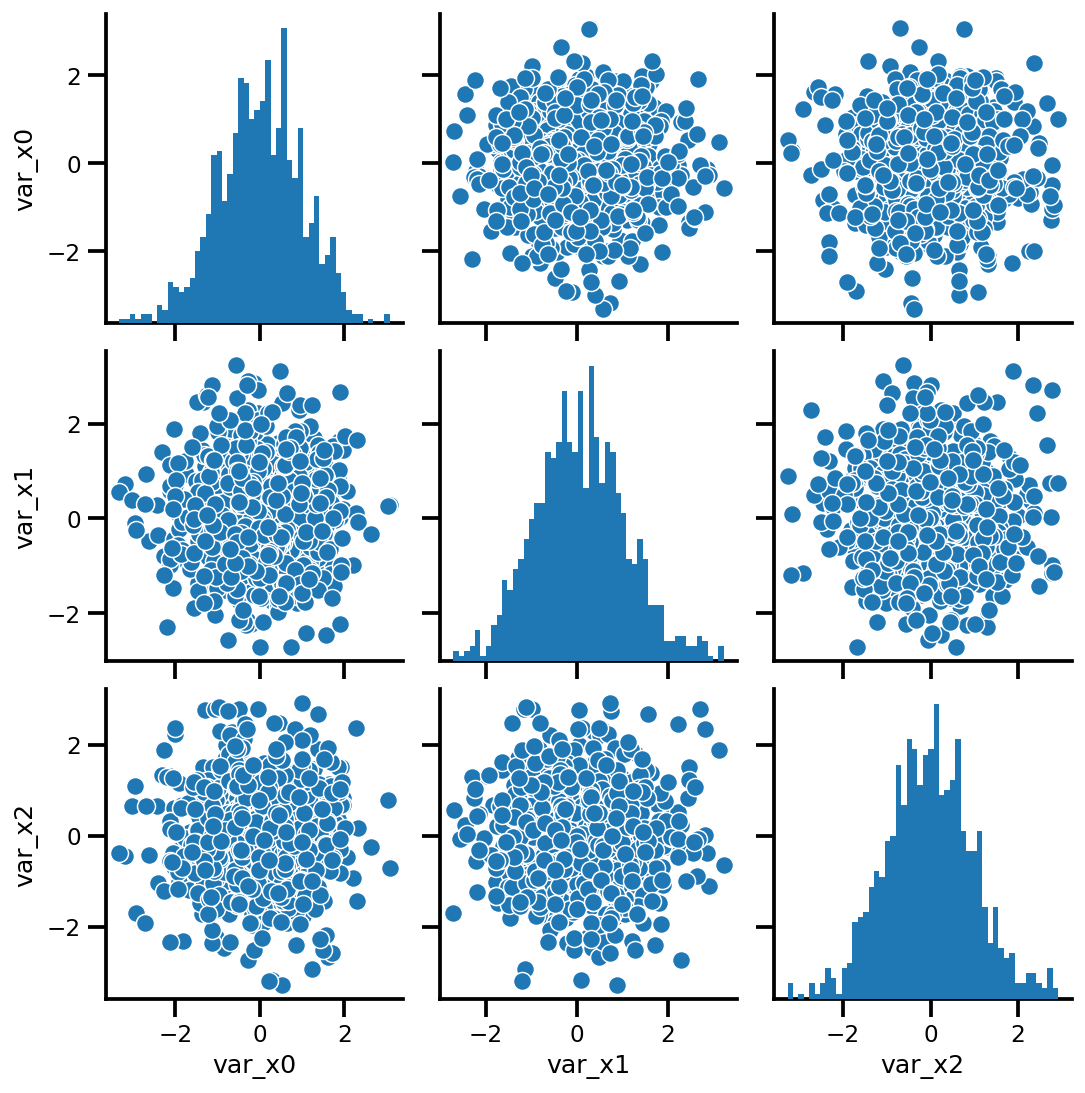

In [94]:

sns.pairplot(df, diag_kws={'bins': 50})

In [95]:
# Probability
logging.info(f"Predicitng the probability...")
t0 = time.time()
X_prob = old_rbig_model.predict_proba(subset.values)
t1 = time.time() - t0
logging.info(f"Time Taken: {t1:.2f} secs")

probs_cubes = get_information(X_prob, subset.index, 'prob')

2020-05-28 10:13:10,251: INFO: Predicitng the probability...
2020-05-28 10:13:10,446: INFO: Time Taken: 0.19 secs


In [96]:
def plot_all(probs_cubes):
    fig, ax = plt.subplots()
    probs_cubes.probability.mean(dim='time').plot(
        ax=ax, robust=True, cmap='Reds', 
        cbar_kwargs={'label': "Probability"}
    )
    
#     probs_cubes.probability.mean(dim=['lat','lon']).plot(
#         ax=ax
#     )

    fig, ax = plt.subplots()
    probs_cubes.log_probability.mean(dim='time').plot(
        ax=ax, robust=True, cmap='Reds', 
        cbar_kwargs={'label': "Log Probability"}
    )

    fig, ax = plt.subplots()
    probs_cubes.shannon_info.mean(dim='time').plot(
        ax=ax, robust=True, cmap='Reds', 
        cbar_kwargs={'label': "Shannon Information"}
    )

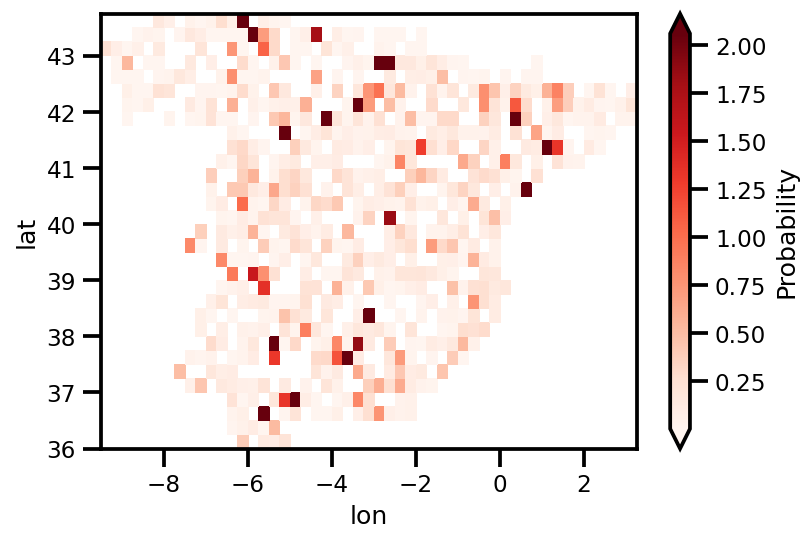

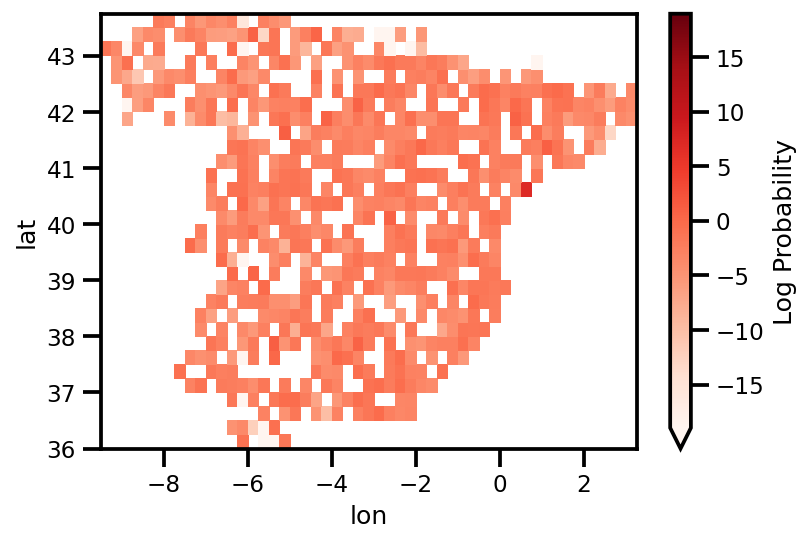

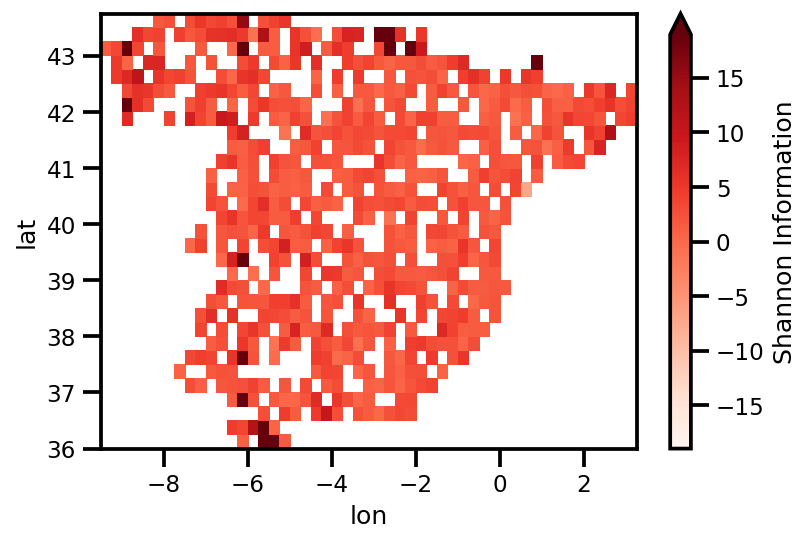

In [97]:
plot_all(probs_cubes)

In [67]:
# ==================================
# Model - Gaussianization (New way)
# ==================================
logger.setLevel(logging.INFO)
n_layers = 10_000
rotation_type = 'PCA'
random_state = 0
zero_tolerance = 60
pdf_extension = 20
pdf_resolution = None
tolerance = None
method = 'custom'
n_quantiles = 50
# Initialize RBIG class
rbig_model = RBIG(
    n_layers=n_layers, 
    rotation_type=rotation_type, 
    random_state=random_state, 
    zero_tolerance=zero_tolerance,
    tolerance=tolerance,
    pdf_extension = pdf_extension,
    verbose=1,
    method=method,
    n_quantiles=n_quantiles
)

# fit model to the data
logging.info(f"Gaussianizing data...")
t0 = time.time()
rbig_model.fit(subset.values.copy())
t1 = time.time() - t0
logging.info(f"Time Taken: {t1:.2f} secs")

# # forward transformation
# logging.info(f"Forward Transform...")
# t0 = time.time()
# X2_trans = rbig_model.transform(subset.values)
# t1 = time.time() - t0
# logging.info(f"Time Taken: {t1:.2f} secs")

# # inverse transformation
# logging.info(f"Inverse Transform...")
# t0 = time.time()
# X2_approx = rbig_model.inverse_transform(X1_trans)
# t1 = time.time() - t0
# logging.info(f"Time Taken: {t1:.2f} secs")

# # jacobian
# logging.info(f"Calculating the Jacobian...")
# t0 = time.time()
# X2_ldj, X2j_trans = rbig_model.jacobian(subset.values)
# t1 = time.time() - t0
# logging.info(f"Time Taken: {t1:.2f} secs")


# # jacobian
# logging.info(f"Calculating the Log Determinant Jacobian...")
# t0 = time.time()
# X2_j, X2j_trans = rbig_model.log_det_jacobian(subset.values)
# t1 = time.time() - t0
# logging.info(f"Time Taken: {t1:.2f} secs")



2020-05-28 10:02:55,477: INFO: Gaussianizing data...
2020-05-28 10:02:55,838: INFO: Time Taken: 0.36 secs


In [230]:
rbig_model.n_layers, rbig_model.total_correlation()

(79, 1.6650560062110156)

In [231]:
X_prob.mean(), Xn_prob.mean()

(8.808554116540166e+17, 2.338728539911919e+111)

In [233]:
Xn_g = rbig_model.transform(subset.values.copy())

Xn_ll = -stats.norm.logpdf(Xn_g).sum(-1).mean()
Xn_ng = neg_entropy_normal(Xn_g)
Xn_mll = -stats.norm.logpdf(Xn_g).mean(axis=0)
Xn_mll

array([1.5  , 1.491, 1.505, 1.485, 1.499, 1.486])

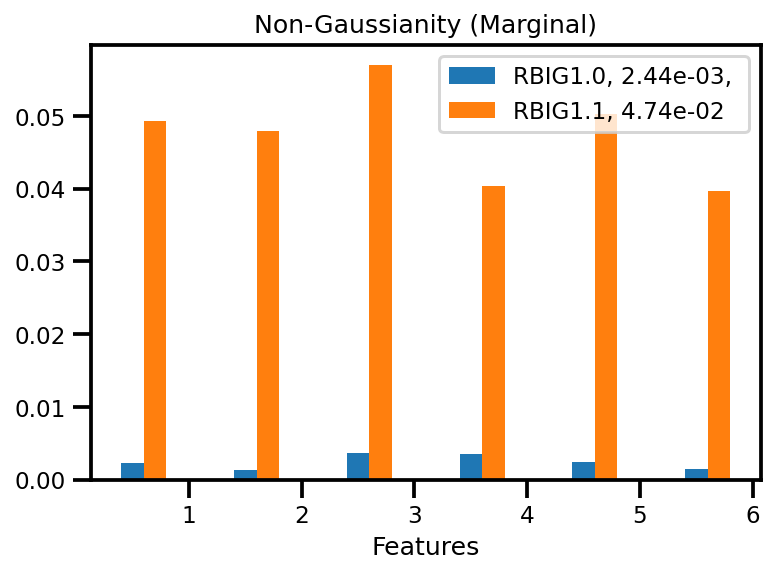

In [234]:
fig, ax = plt.subplots()
width = 0.2
ax.bar(labels, X_ng, 0.2, label=f'RBIG1.0, {X_ng.mean():.2e}, ')
ax.bar(labels + 0.2, Xn_ng, 0.2, label=f'RBIG1.1, {Xn_ng.mean():.2e}')
ax.legend()
ax.set(
    title="Non-Gaussianity (Marginal)",
    xlabel='Features',
    
)
plt.show()

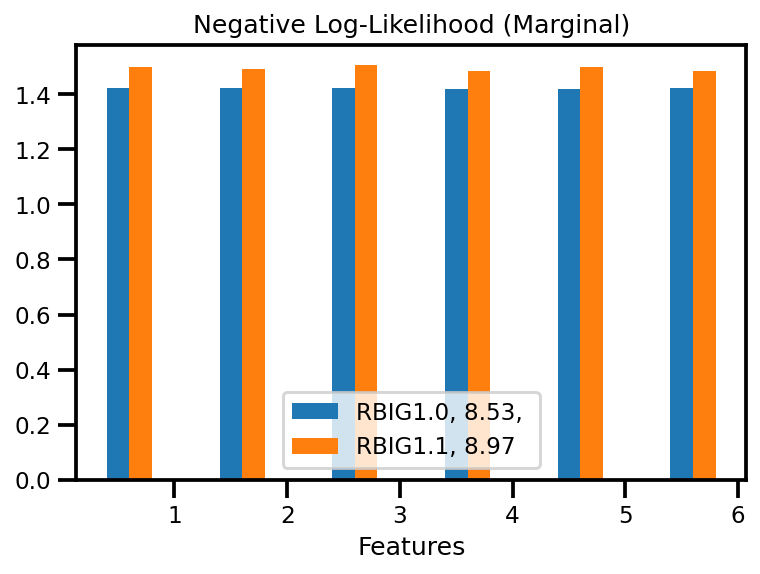

In [235]:
fig, ax = plt.subplots()
width = 0.2
ax.bar(labels, X_mll, 0.2, label=f'RBIG1.0, {X_ll:.2f}, ')
ax.bar(labels + 0.2, Xn_mll, 0.2, label=f'RBIG1.1, {Xn_ll:.2f}')
ax.legend()
ax.set(
    title="Negative Log-Likelihood (Marginal)",
    xlabel='Features',
    
)
plt.show()

In [160]:
from scipy import stats

Xn_g = rbig_model.transform(subset.values.copy())
print(stats.norm.logpdf(Xn_g).sum(-1).mean())
print(stats.norm.logpdf(Xn_g).mean(axis=0))

-8.96600103115174
[-1.5   -1.491 -1.505 -1.485 -1.499 -1.486]


-8.531258910384436

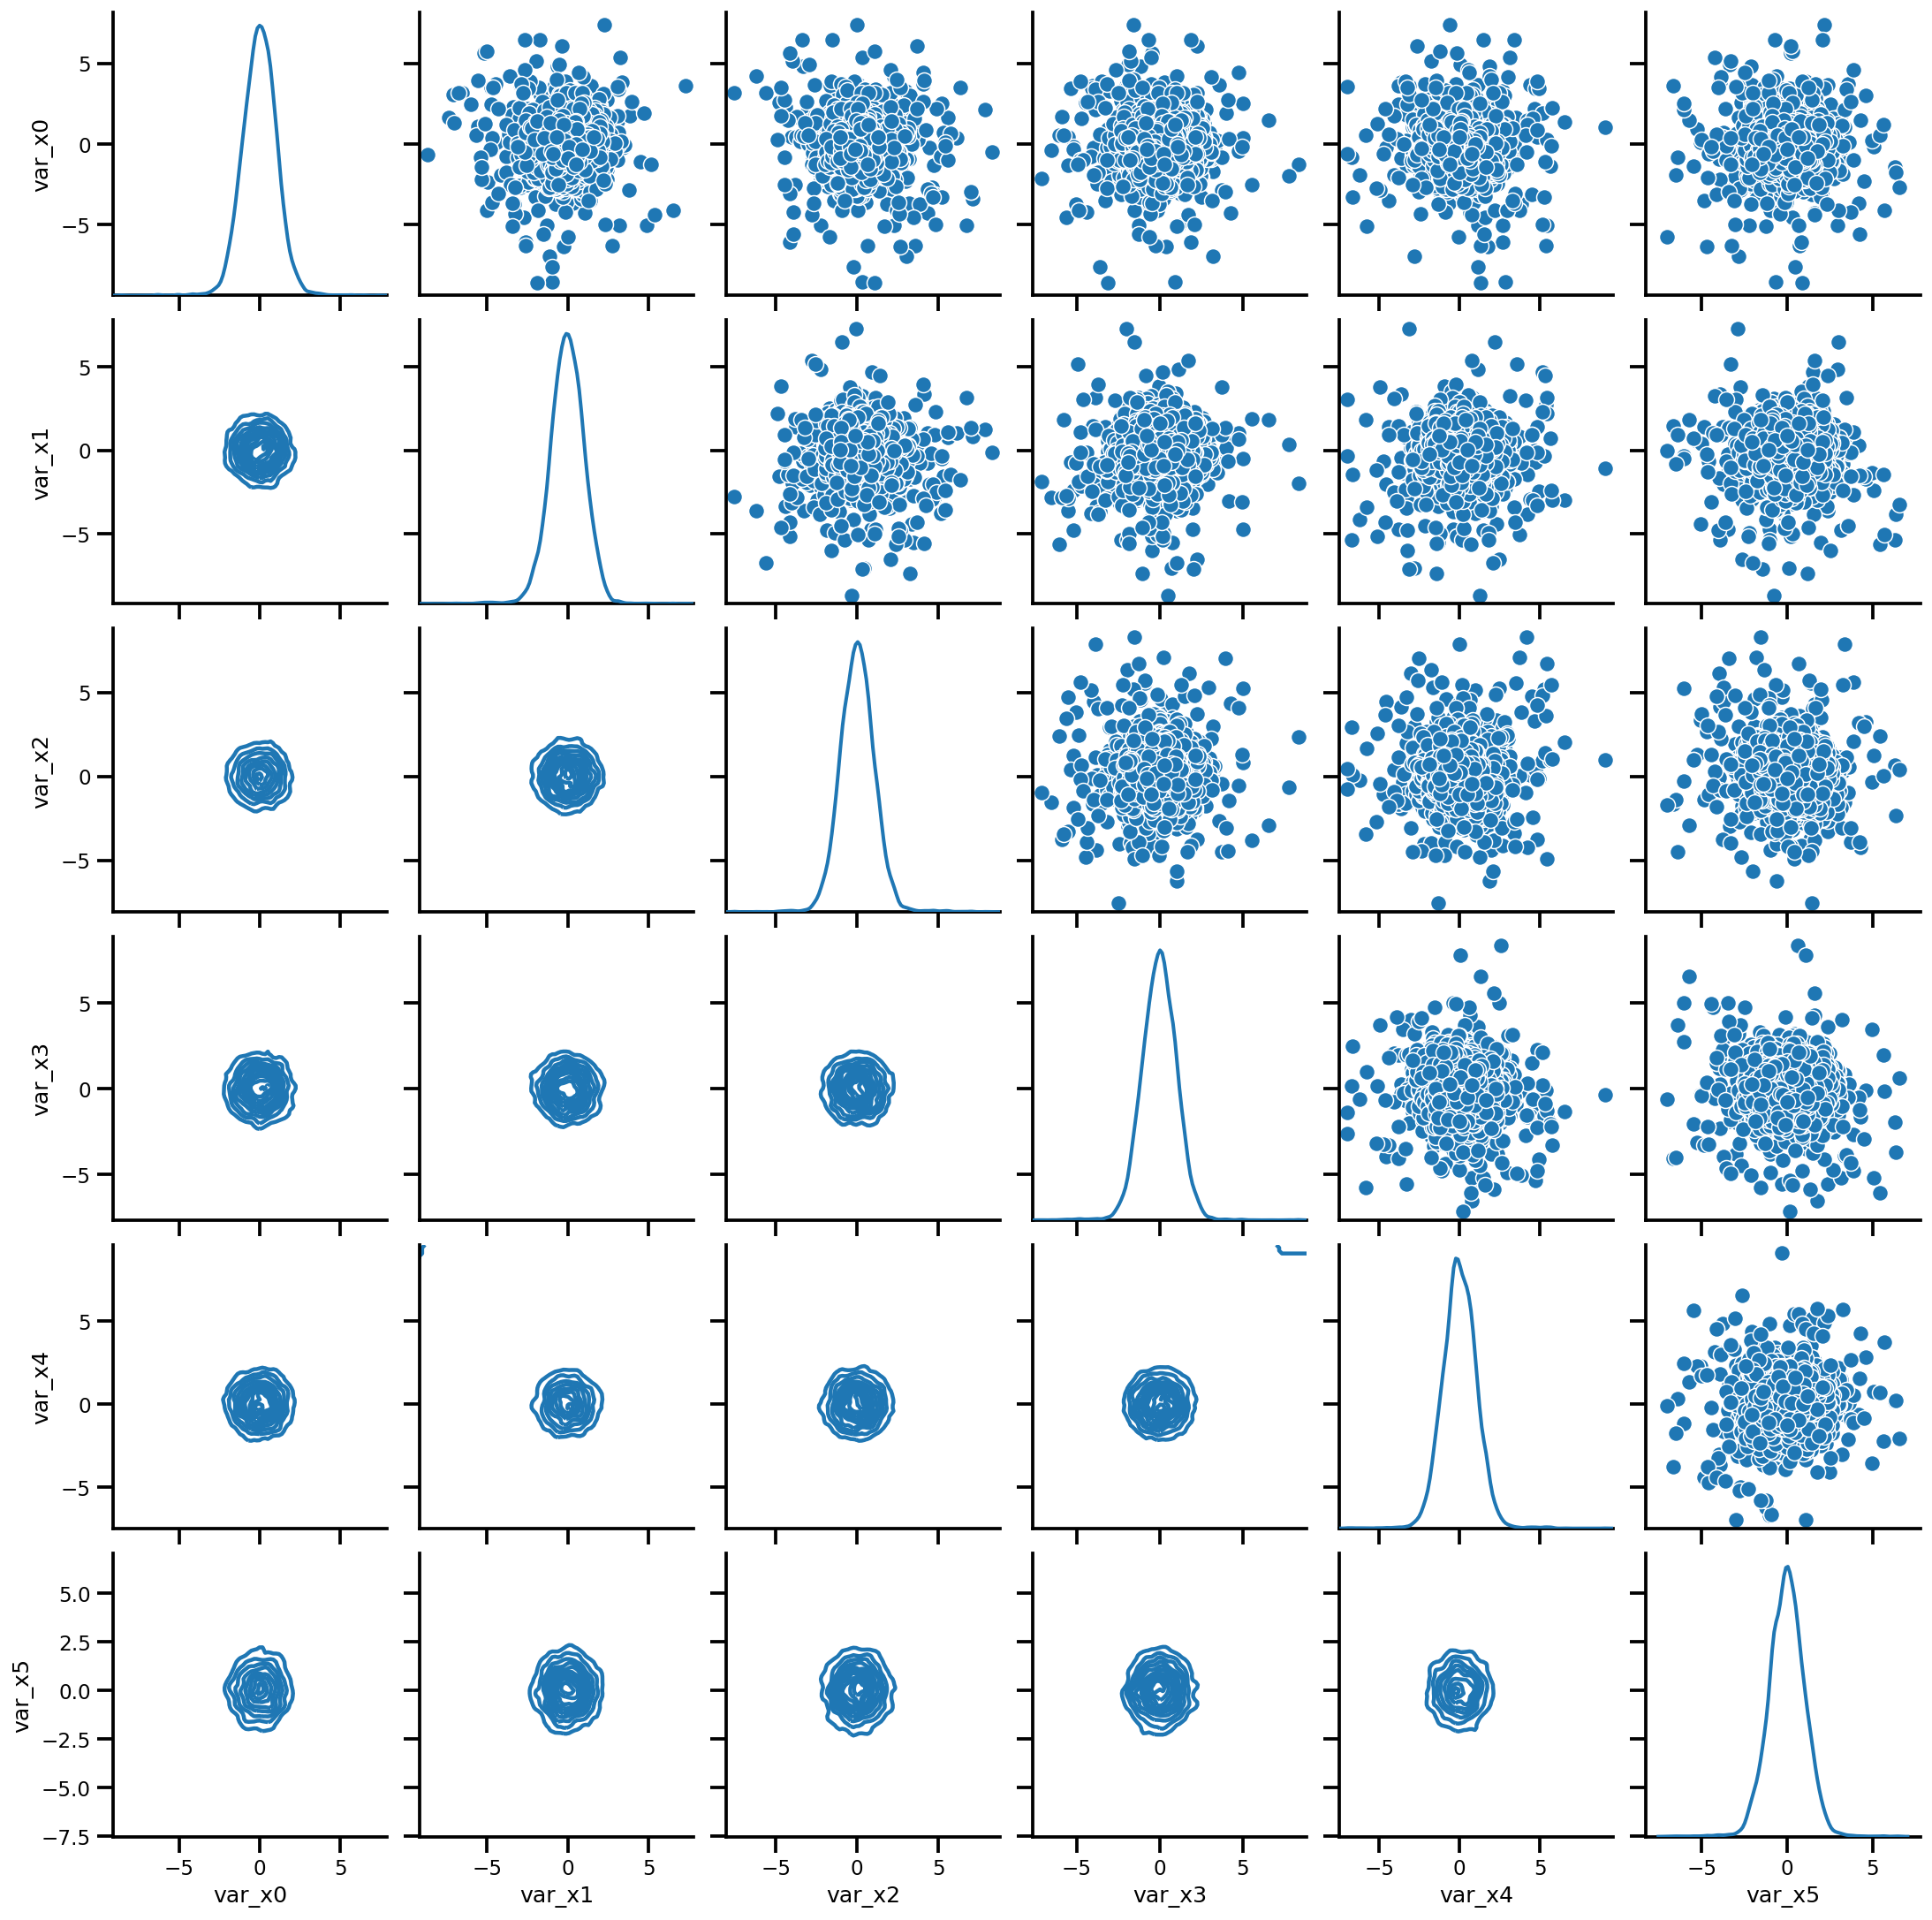

In [237]:
# Xn_g = rbig_model.transform(subset.values.copy())

sns.pairplot(pd.DataFrame(data=Xn_g, index=subset.index, columns=subset.columns), diag_kws={'bins': 50})

In [ ]:
# Xn_g = rbig_model.transform(subset.values.copy())

# sns.pairplot(, diag_kws={'bins': 50})
df = pd.DataFrame(data=Xn_g, index=subset.index, columns=subset.columns)
g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, colors="C0")
g.map_diag(sns.kdeplot, lw=2)

In [115]:
# Probability
logger.setLevel(logging.DEBUG)

logging.info(f"Predicitng the probability...")
t0 = time.time()
Xn_prob = rbig_model.predict_proba(subset.values.copy())
t1 = time.time() - t0
logging.info(f"Time Taken: {t1:.2f} secs")

probsn_cubes = get_information(Xn_prob, subset.index, 'prob')

2020-05-18 12:42:40,522: INFO: Predicitng the probability...
2020-05-18 12:42:42,003: DEBUG: Z: [-5.251 -1.552  0.025  1.596  6.542]
2020-05-18 12:42:42,012: DEBUG: Z_logprob: [-22.321  -2.683  -1.127  -0.921  -0.919]
2020-05-18 12:42:42,015: DEBUG: X_ldj: [-6.191 -0.88   0.254  1.338 88.291]
2020-05-18 12:42:42,017: DEBUG: X_logprob: [-22.047 -11.39   -6.443  -3.186 265.647]
2020-05-18 12:42:42,019: DEBUG: XProb: [2.660e-010 1.131e-005 1.592e-003 4.133e-002 2.339e+115]
2020-05-18 12:42:42,019: INFO: Time Taken: 1.50 secs


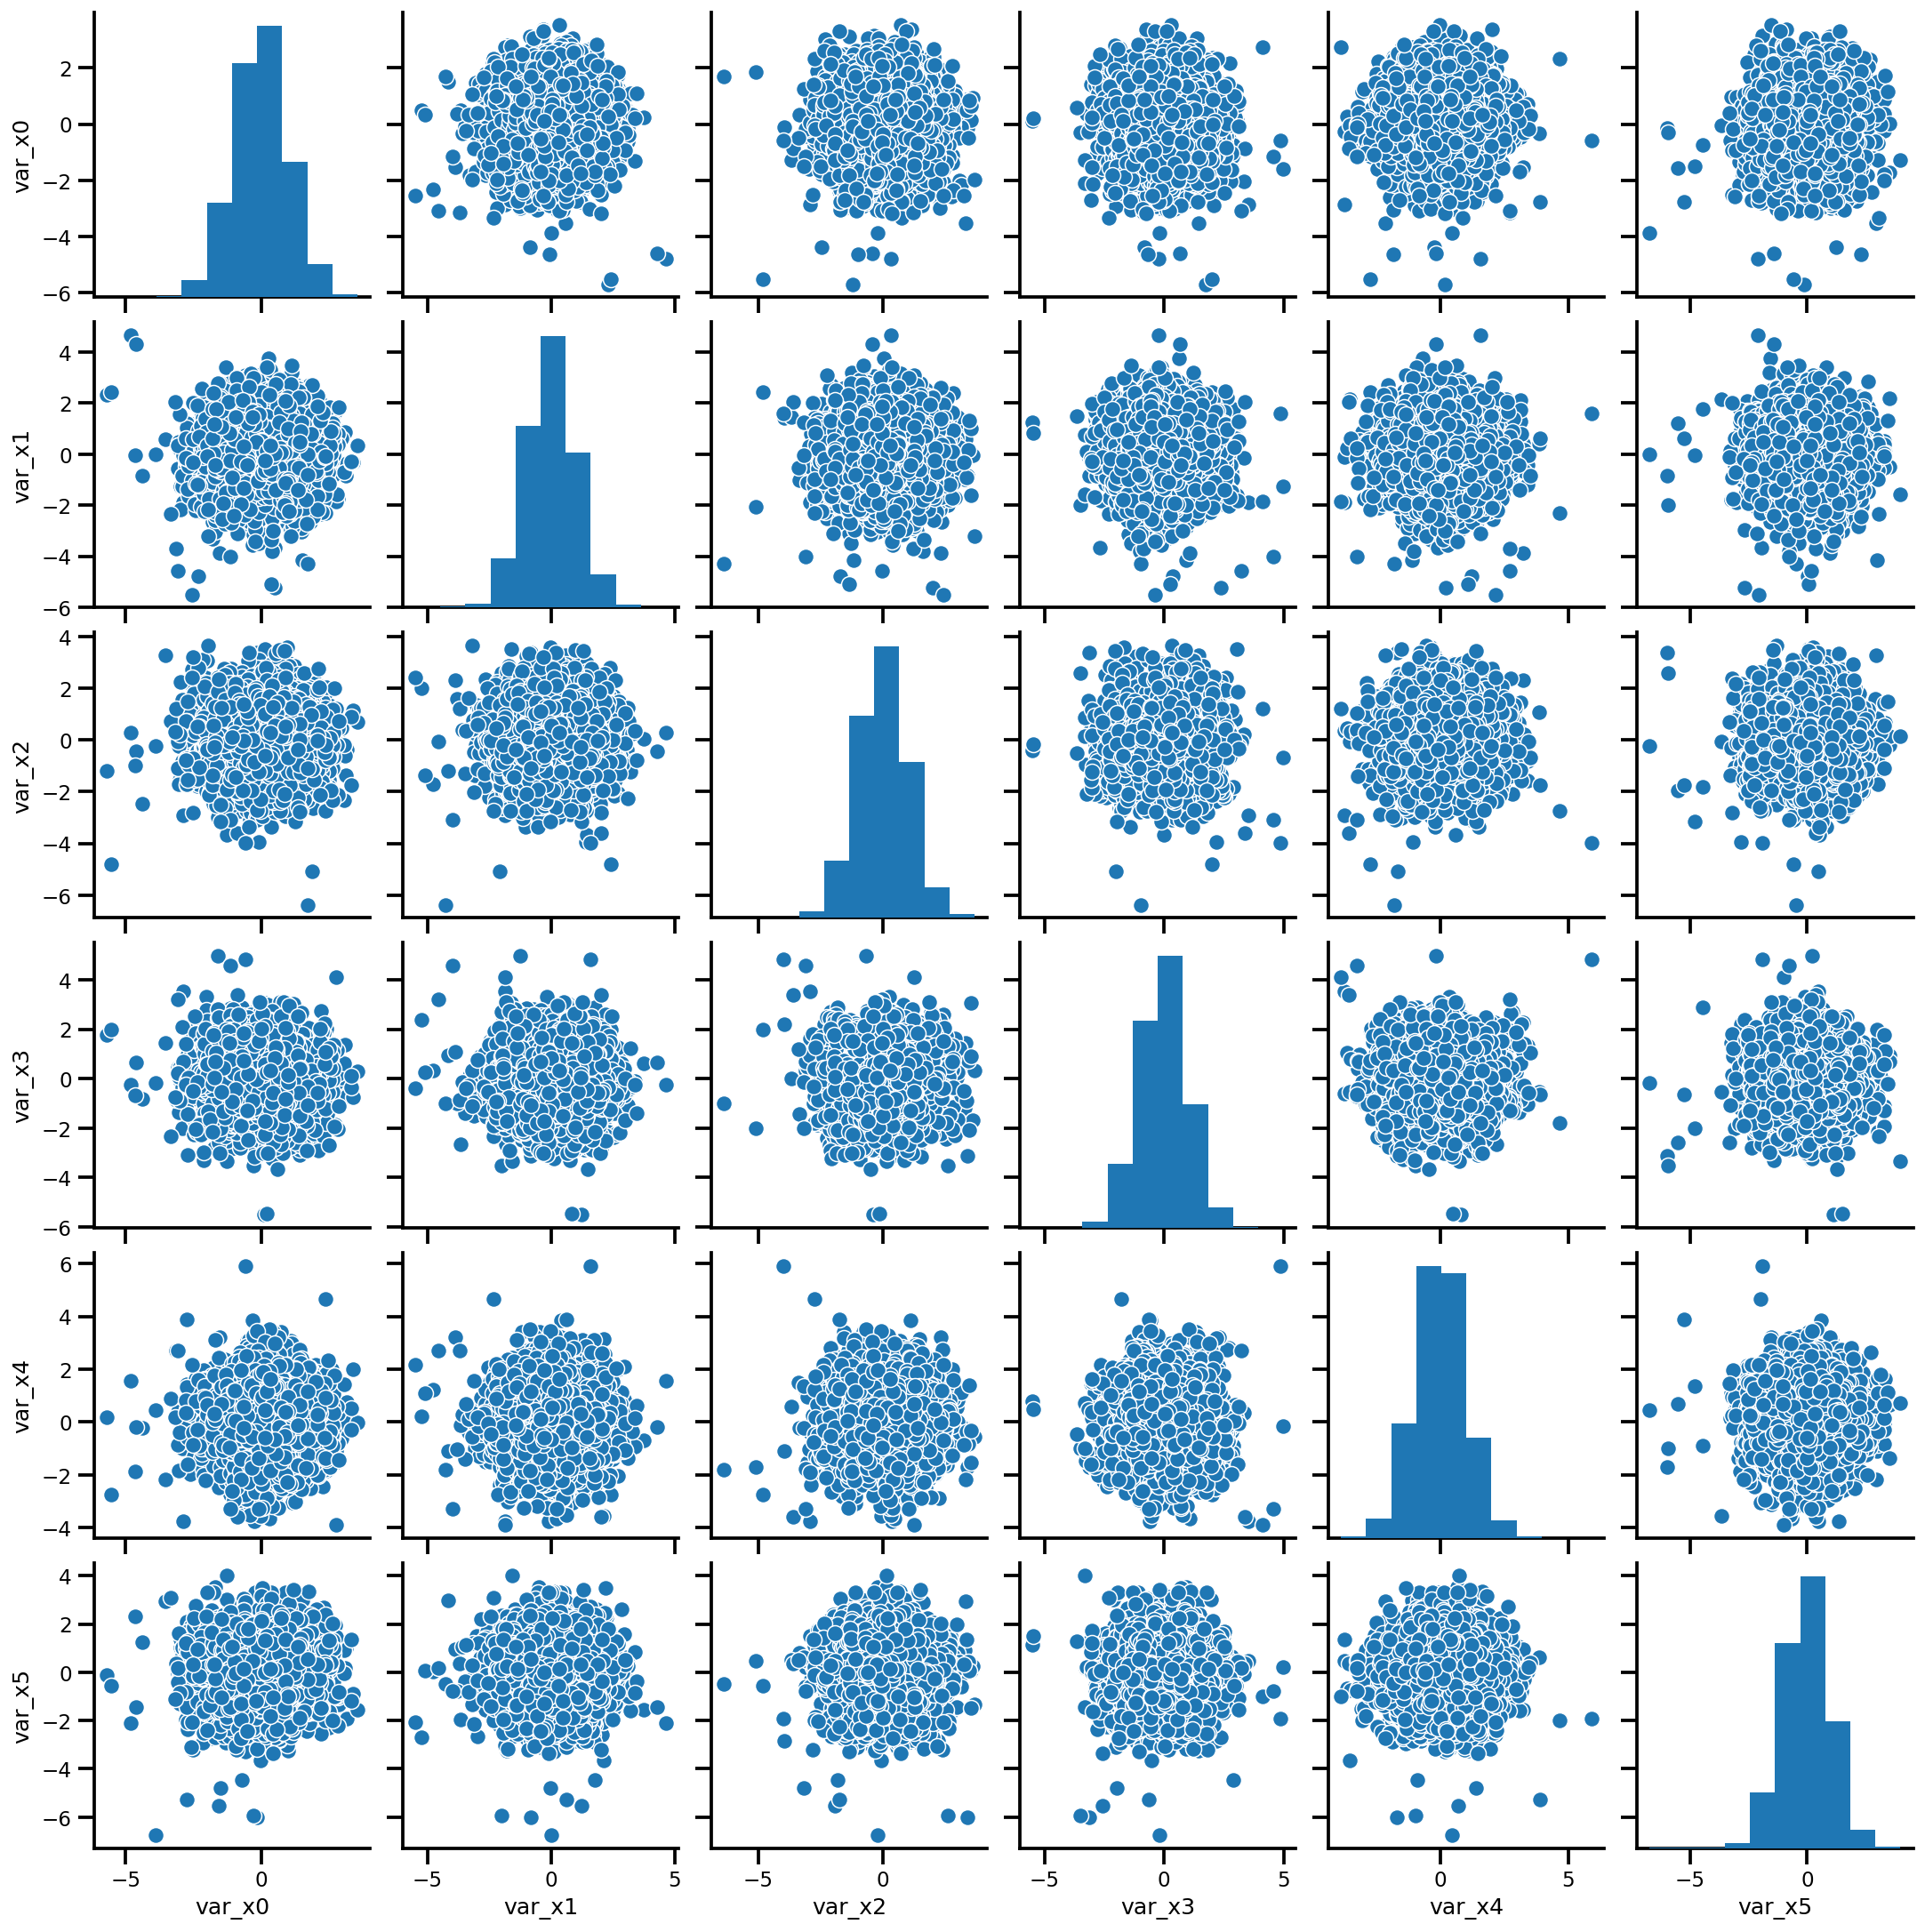

In [120]:
X_g = rbig_model.transform(subset.values.copy())

sns.pairplot(pd.DataFrame(data=X_g, index=subset.index, columns=subset.columns), )

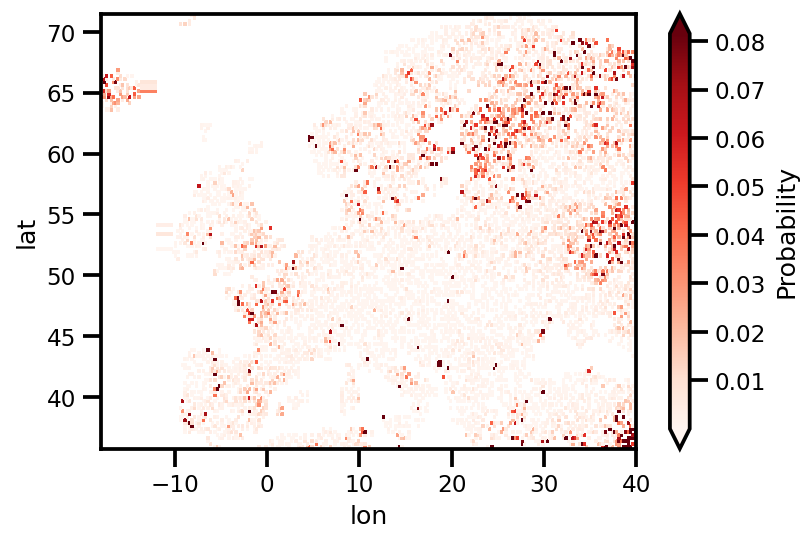

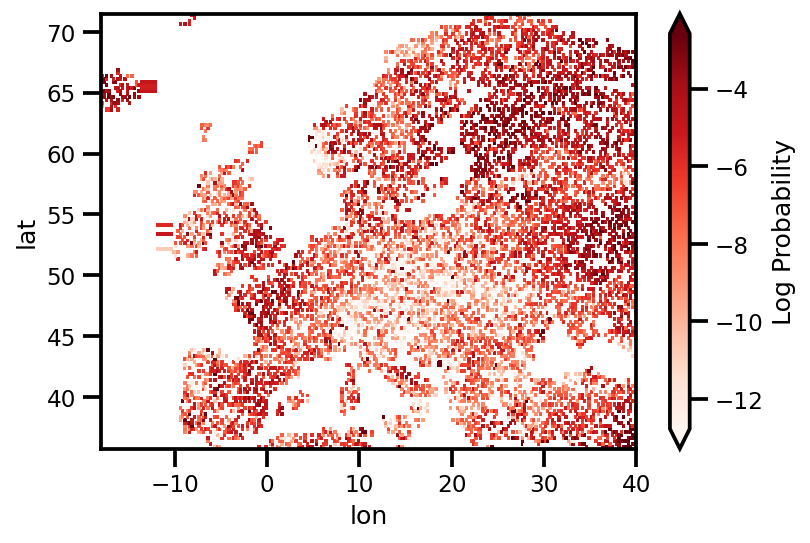

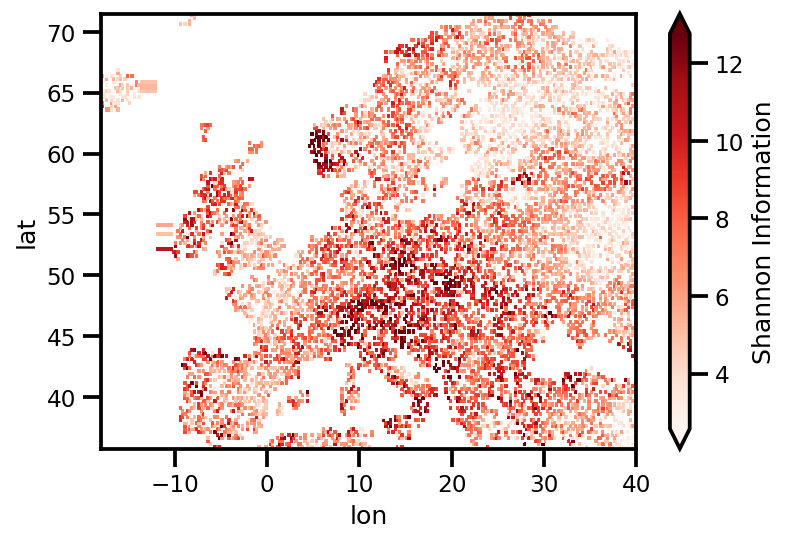

In [116]:
logger.setLevel(logging.INFO)
plot_all(probsn_cubes)

In [ ]:
# np.percentile(Xn_prob, [10, 50, 95])
jacs = np.vstack((rbig_model.jacs_))
jacs_full = np.vstack((rbig_model.jacs_sum_))

In [ ]:
logger.setLevel(logging.INFO)
plt.figure()
plt.hist(jacs.ravel(), bins=100);

plt.figure()
plt.hist(jacs_full.ravel(), bins=100);

In [ ]:
plt.figure()
plt.plot(jacs)
plt.legend(['Min', '5%', '10%', '50%', '90%', '95%', 'Max'])
plt.xlabel('Layer')

plt.figure()
plt.plot(jacs_full)
plt.legend(['Min', '5%', '10%', '50%', '90%', '95%', 'Max'])
plt.xlabel('Layer')

In [ ]:
logger.setLevel(logging.INFO)
plot_all(probsn_cubes)

In [65]:
from scipy import stats

In [80]:
probs_cubes = get_information(X_prob, subset.index, 'logprob')

In [42]:
def plot_all(probs_cubes):
    fig, ax = plt.subplots()
    probs_cubes.probability.mean(dim='time').plot(
        ax=ax, robust=True, cmap='Reds', 
        cbar_kwargs={'label': "Probability"}
    )

    fig, ax = plt.subplots()
    probs_cubes.log_probability.mean(dim='time').plot(
        ax=ax, robust=True, cmap='Reds', 
        cbar_kwargs={'label': "Log Probability"}
    )

    fig, ax = plt.subplots()
    probs_cubes.shannon_info.mean(dim='time').plot(
        ax=ax, robust=True, cmap='Reds', 
        cbar_kwargs={'label': "Shannon Information"}
    )

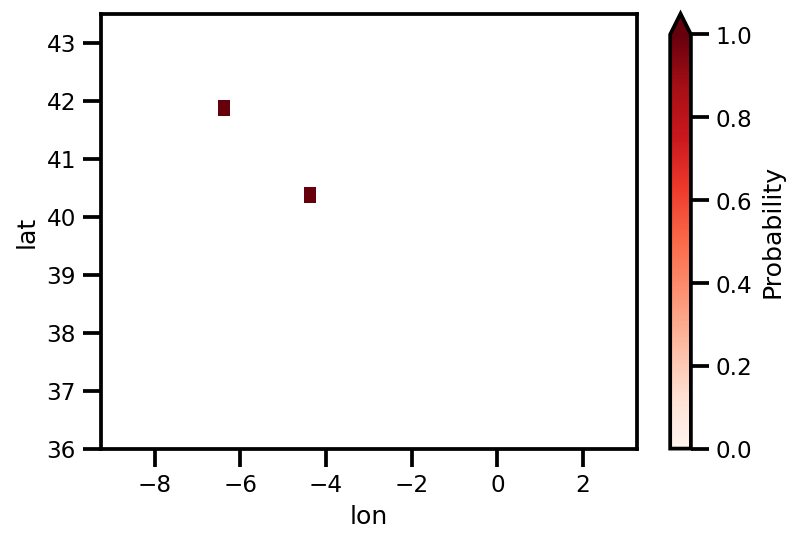

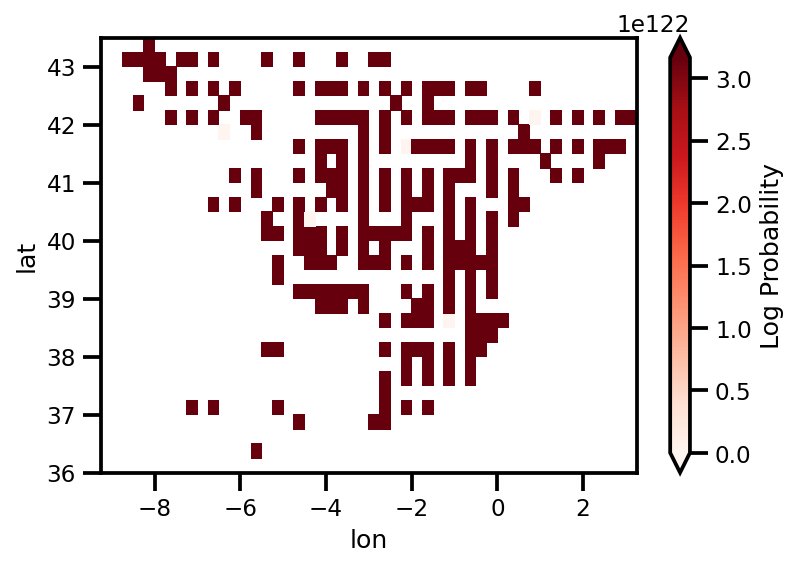

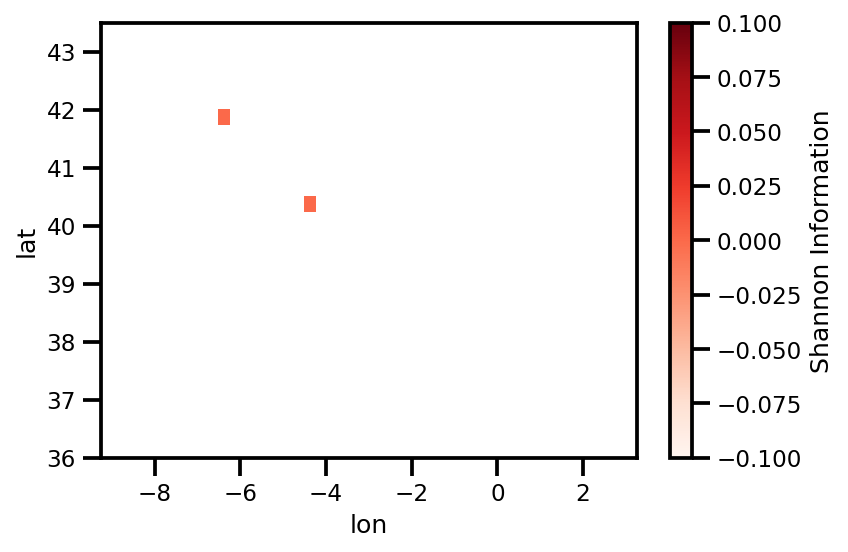

In [26]:
fig, ax = plt.subplots()
probs_cubes.probability.mean(dim='time').plot(
    ax=ax, vmax=0, robust=True, cmap='Reds', 
    cbar_kwargs={'label': "Probability"}
)

fig, ax = plt.subplots()
probs_cubes.log_probability.mean(dim='time').plot(
    ax=ax, vmax=0.0, robust=True, cmap='Reds', 
    cbar_kwargs={'label': "Log Probability"}
)

fig, ax = plt.subplots()
probs_cubes.shannon_info.mean(dim='time').plot(
    ax=ax, robust=True, cmap='Reds', 
    cbar_kwargs={'label': "Shannon Information"}
)

In [313]:
X_prob_df = pd.DataFrame(
    data=X_prob, 
    index=subset.index,
    columns=['logp']
)

Text(0, 0.5, 'New')

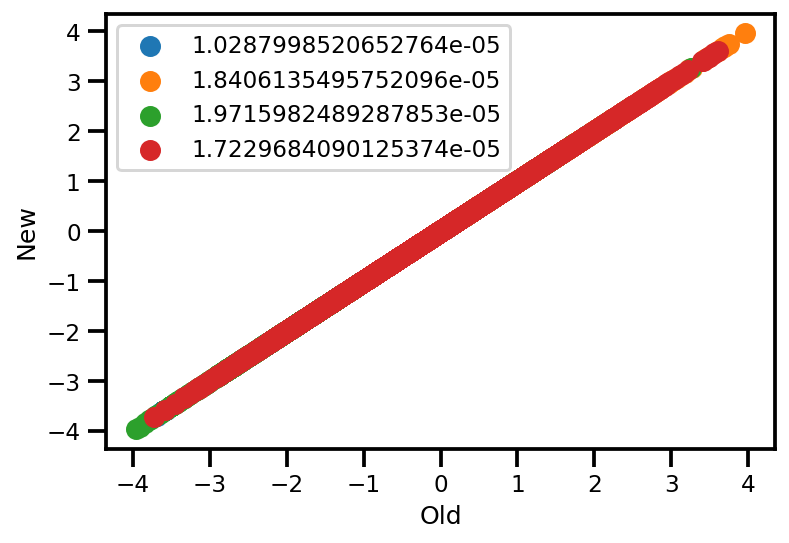

In [314]:
for it1, it2 in zip(X1_trans.T, X2_trans.T):
    plt.scatter(it1, it2, label=f"{mean_absolute_error(it1, it2)}")
plt.legend()
plt.xlabel("Old")
plt.ylabel("New")

Text(0, 0.5, 'New')

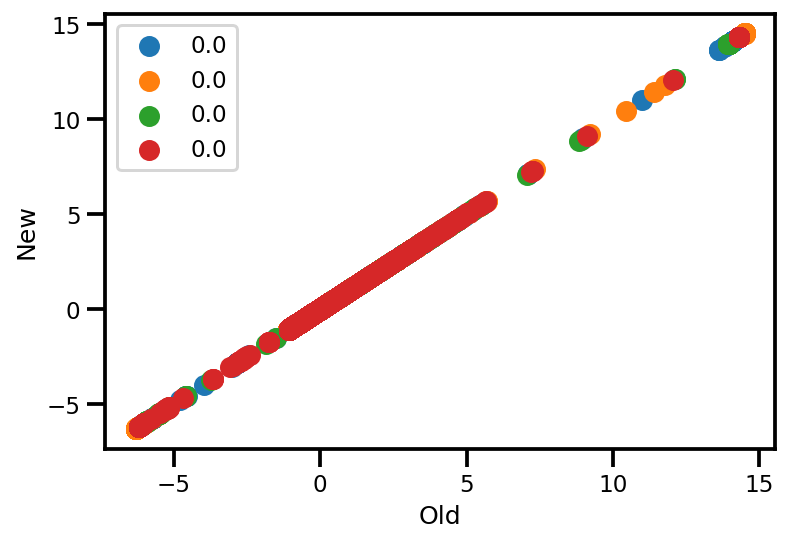

In [315]:
for it1, it2 in zip(X1_approx.T, X2_approx.T):
    plt.scatter(it1, it2, label=f"{mean_absolute_error(it1, it2)}")
plt.legend()
plt.xlabel("Old")
plt.ylabel("New")

In [318]:
rbig_model.total_correlation(), old_rbig_model.total_correlation()

(17.71904278563887, 17.71904278563887)

In [104]:
# ==================================
# Model - Gaussianization (New way)
# ==================================

logging.info(f"Gaussianizing data...")

t0 = time.time()
n_layers = 10_000
rotation_type = 'PCA'
random_state = 0
zero_tolerance = 60
pdf_extension = None
pdf_resolution = None
tolerance = None

# Initialize RBIG class
rbig_model = RBIG(n_layers=n_layers, 
                  rotation_type=rotation_type, 
                  random_state=random_state, 
                  pdf_extension = 50,
                  zero_tolerance=zero_tolerance,
                  tolerance=tolerance)

# fit model to the data
rbig_model.fit(subset)
t1 = time.time() - t0
logging.info(f"Time Taken: {t1:.2f} secs")


2020-05-13 14:06:42,313: INFO: Gaussianizing data...
2020-05-13 14:06:42,316: INFO: New way...
2020-05-13 14:06:43,398: INFO: Time Taken: 1.08 secs


In [77]:
rbig_model.n_layers

1697

In [78]:
rbig_model.total_correlation()

26.25788983611872

In [52]:
# get the probability estimates
logging.info(f"Getting probability estimates...")
t0 = time.time()
subsamples = 100_000
subset = subset_indices(density_cube_df_norm.values, subsamples)
X_prob = rbig_model.predict_proba(
    density_cube_df_norm.values, n_trials=1, chunksize=100_000, domain='input'
)
t1 = time.time() - t0
logging.info(f"Time Taken: {t1:.2f} secs")

X_prob = pd.DataFrame(
    data=X_prob, 
    index=density_cube_df_norm.index,
    columns=['probability']
)


2020-05-13 12:35:35,612: INFO: Getting probability estimates...
2020-05-13 12:35:45,598: INFO: Time Taken: 9.98 secs


In [320]:
probs_cubes = get_information(X_prob_df)

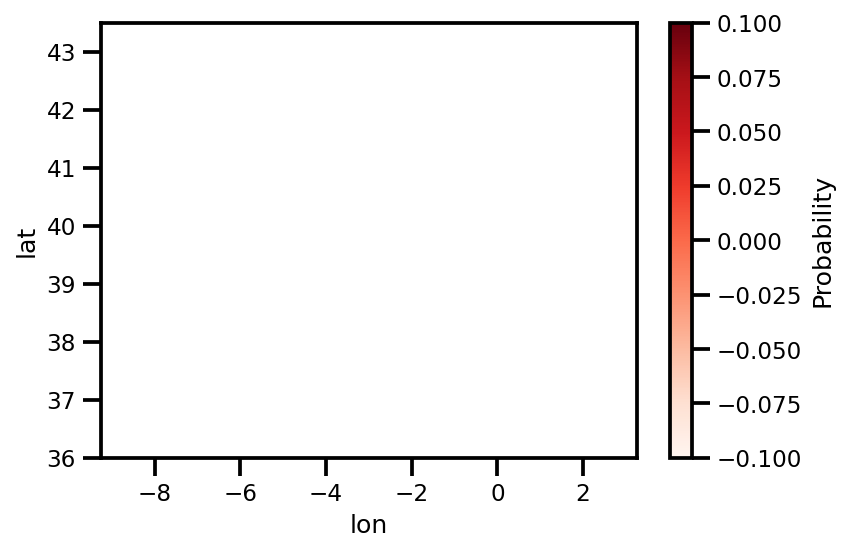

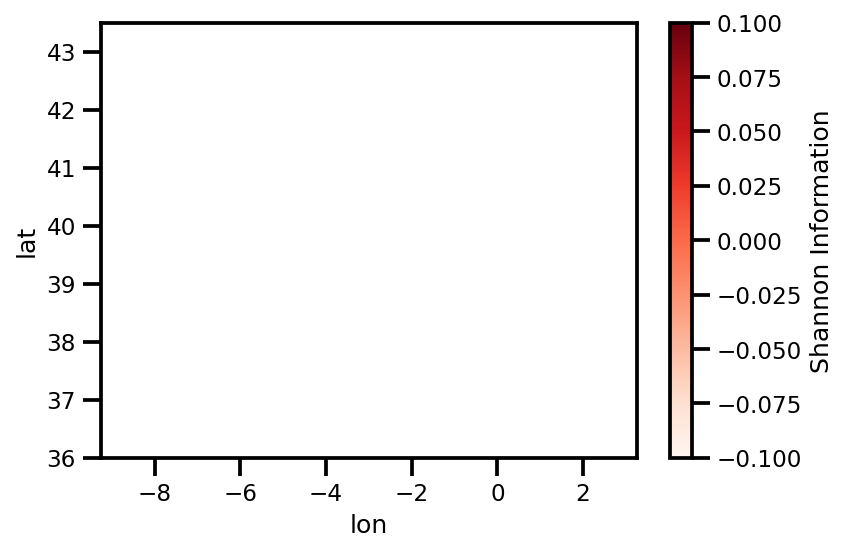

In [321]:
fig, ax = plt.subplots()
probs_cubes.probability.mean(dim='time').plot(
    ax=ax,
    vmin=0, vmax=None, robust=True, cmap='Reds', 
    cbar_kwargs={'label': "Probability"}
)

fig, ax = plt.subplots()
probs_cubes.shannon_info.mean(dim='time').plot(
    ax=ax,
    vmin=0, robust=True, cmap='Reds', 
    cbar_kwargs={'label': "Shannon Information"}
)

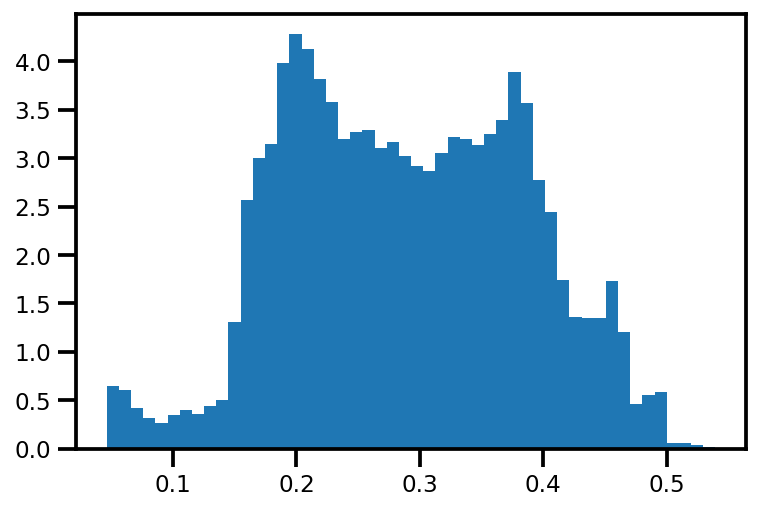

In [92]:
plt.hist(density_cube_df['var_x0'].squeeze(), bins=50, density=True);

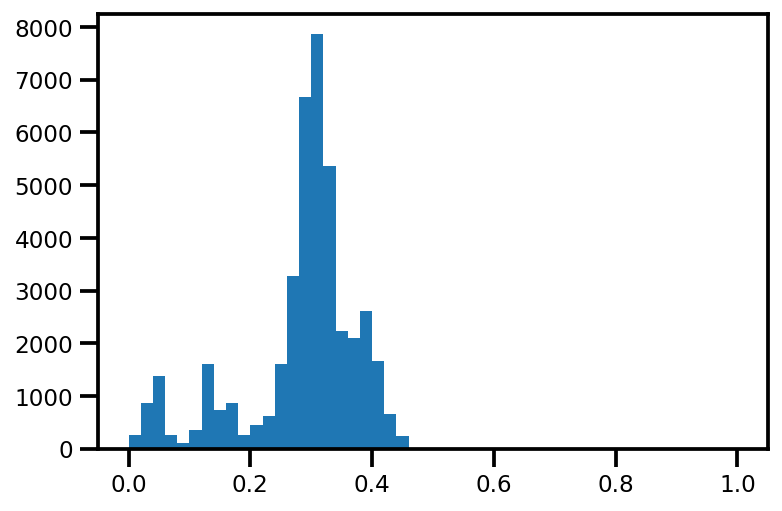

In [93]:
plt.hist(density_cube_df['prob'].squeeze(), bins=50, range=(0, 1.0));